In [1]:
!pip install --no-cache-dir numpy==1.26.4 pandas==2.2.1
!pip install --no-cache-dir torch==2.3.0 torchtext==0.18.0 transformers==4.35.2
!pip install --no-cache-dir matplotlib==3.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 232.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 189.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 285.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 220.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 137.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 165.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 167.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 218.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 143.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 179.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 207.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import BertTokenizer
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchtext.vocab import Vocab, build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import IMDB
import random
from itertools import chain
import pandas as pd
from copy import deepcopy
import csv
import json
import math
from tqdm import tqdm

import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [64]:
# make torch dataset from CSV files, the csv files contains preprocessed data for BERT input

class BERTCSVDataset(Dataset):
    def __init__(self, filename):
        self.data = pd.read_csv(filename)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        try:

            bert_input = torch.tensor(json.loads(row['BERT Input']), dtype=torch.long)
            bert_label = torch.tensor(json.loads(row['BERT Label']), dtype=torch.long)
            segment_label = torch.tensor([int(x) for x in row['Segment Label'].split(',')], dtype=torch.long)
            is_next = torch.tensor(row['Is Next'], dtype=torch.long)
            original_text = row['Original Text']  # If you want to use it
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON for row {idx}: {e}")
            print("BERT Input:", row['BERT Input'])
            print("BERT Label:", row['BERT Label'])
            # Handle the error, e.g., by skipping this row or using default values
            return None  # or some default values

            # Tokenizing the original text with BERT
        encoded_input = self.tokenizer.encode_plus(
            original_text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        return(bert_input, bert_label, segment_label, is_next, input_ids, attention_mask, original_text)

In [65]:
# we will now create a collate function that will carry out the transformations in the batches from data iterator
PAD_IDX = 0
def collate_batch(batch):
  bert_inputs_batch, bert_labels_batch, segment_labels_batch, is_nexts_batch, input_ids_batch, attention_mask_batch, original_text_battch = [],[],[],[],[],[],[]
  for bert_input, bert_label, segment_label, is_next,input_ids,attention_mask,original_text in batch:
    # Convert each sequence to a tensor and append to the respective list
        bert_inputs_batch.append(torch.tensor(bert_input, dtype=torch.long))
        bert_labels_batch.append(torch.tensor(bert_label, dtype=torch.long))
        segment_labels_batch.append(torch.tensor(segment_label, dtype=torch.long))
        is_nexts_batch.append(is_next)
        input_ids_batch.append(input_ids)
        attention_mask_batch.append(attention_mask)
        original_text_battch.append(original_text)

  # Pad the sequences in the batch
  bert_inputs_final = pad_sequence(bert_inputs_batch, padding_value=PAD_IDX, batch_first=False)
  bert_labels_final = pad_sequence(bert_labels_batch, padding_value=PAD_IDX, batch_first=False)
  segment_labels_final = pad_sequence(segment_labels_batch, padding_value=PAD_IDX, batch_first=False)
  is_nexts_batch = torch.tensor(is_nexts_batch, dtype=torch.long)

  return bert_inputs_final, bert_labels_final, segment_labels_final, is_nexts_batch








In [66]:
BATCH_SIZE = 2

train_dataset_path = 'bert_train_data.csv'
test_dataset_path = 'bert_test_data.csv'

train_dataset = BERTCSVDataset(train_dataset_path)
test_dataset = BERTCSVDataset(test_dataset_path)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [67]:
# next we come to model creation, we need three types of encodings:
# token embedding
# positional embedding
# segment embedding

# finally we will make class for BERT embedding

EMBEDDING_DIM = 10

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Define the PositionalEncoding class as a PyTorch module for adding positional information to token embeddings
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        # Create a positional encoding matrix as per the Transformer paper's formula
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: torch.Tensor):
        # Apply the positional encodings to the input token embeddings

        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [68]:
class BERTEmbedding (nn.Module):

    def __init__(self, vocab_size, emb_size ,dropout=0.1,train=True):

        super().__init__()

        self.token_embedding = TokenEmbedding( vocab_size,emb_size )
        self.positional_encoding = PositionalEncoding(emb_size,dropout)
        self.segment_embedding = nn.Embedding(3, emb_size)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, bert_inputs, segment_labels=False):
        my_embeddings=self.token_embedding(bert_inputs)
        if self.train:
          x = self.dropout(my_embeddings + self.positional_encoding(my_embeddings) + self.segment_embedding(segment_labels))
        else:
          x = my_embeddings + self.positional_encoding(my_embeddings)

        return x

In [69]:
# Next step is to create a BERT model

#key components:
#
#Initialization: The BERT class is defined as a subclass of torch.nn.Module. It initializes the BERT model
#with parameters such as vocabulary size, model dimension, number of layers, number of attention heads, and dropout rate.

#Embedding Layer: The BERT model includes an embedding layer that combines token
#embeddings and segment embeddings using the BERTEmbedding class.

#Transformer Encoder: Transformer Encoder layers are used to encode the input embeddings.
#The number of layers, attention heads, dropout rate, and model dimension are specified based on the defined parameters.

#Next Sentence Prediction: The model has a linear layer for Next Sentence Prediction.
#It takes the output from the Transformer encoder and predicts the relationship between two consecutive sentences, classifying them into two classes.

#Masked Language Modeling: The model also includes a linear layer for Masked Language Modeling.
#It predicts the masked tokens in the input sequence by taking the output from the Transformer encoder and making predictions across the vocabulary.

#Forward Pass: The forward method defines the forward pass of the BERT model.
#It takes input tokens (bert_inputs) and segment labels (segment_labels) and returns predictions for Next Sentence Prediction and Masked Language Modeling tasks.



In [70]:
VOCAB_SIZE=147161
batch = 2
count = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load sample batches from dataloader
for batch in train_dataloader:
    bert_inputs, bert_labels, segment_labels, is_nexts = [b.to(device) for b in batch]
    count += 1
    if count == 5:
        break

In [71]:
bert_inputs.shape

torch.Size([140, 2])

In [72]:
#pick a sample input
bert_inputs[:,0]

tensor([   1,    8,   16,  648,   16,    3, 1788,   14,   31,  255,  167, 1872,
         244,    3,    3,   28,   32,   73,   94,    3,    3,   64,   12,   19,
          38,   10,    5,  256,  165,    3,  348,    3,   25,   16,   12,  155,
         139, 8672,    3,   82,    9, 2031,  309,   18,   64,   20,    5,   73,
          38,    7,    3,  404,    5,   73,   92,  288,   15,    5,    3,    7,
          11, 1171,    3,  125,  807,   22,   12, 1561,    6,    2,   12,   27,
          25,   64,  287,   12,   30,    5,   73,    3,    6,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], device='cuda:0')

In [73]:
segment_labels.shape

torch.Size([140, 2])

In [74]:
segment_labels[:,0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')

In [75]:
# Instantiate the TokenEmbedding
token_embedding = TokenEmbedding(VOCAB_SIZE, emb_size=EMBEDDING_DIM )
token_embedding.to(device)
# Get the token embeddings for a sample input
t_embeddings = token_embedding(bert_inputs)

#Each token is transformed into a tensor of size emb_size
print(f"Dimensions of token embeddings: {t_embeddings.size()}") # Expected: (sequence_length, batch_size, EMBEDDING_DIM)
#Check the embedded vectors for first 3 tokens of the first sample in the batch
# you get embeddings[i,0,:] where i refers to the i'th token of the first sample in the batch (b=0)
for i in range(3):
    print(f"Token Embeddings for the {i}th token of the first sample: {t_embeddings[i,0,:]}")

Dimensions of token embeddings: torch.Size([140, 2, 10])
Token Embeddings for the 0th token of the first sample: tensor([-3.2079,  1.1800, -0.9440,  0.0729,  1.1978,  1.7517, -0.0080, -1.5066,
         2.8818, -1.7449], device='cuda:0', grad_fn=<SliceBackward0>)
Token Embeddings for the 1th token of the first sample: tensor([-3.3793, -2.1977,  4.4691,  1.0091,  3.7115, -5.2992, -4.1061,  1.7831,
        -0.8865, -0.5313], device='cuda:0', grad_fn=<SliceBackward0>)
Token Embeddings for the 2th token of the first sample: tensor([ 4.3730,  6.8717, -2.9076, -1.3903, -1.7141,  1.0198,  0.5748,  0.7901,
        -0.7820, -1.1074], device='cuda:0', grad_fn=<SliceBackward0>)


In [76]:
positional_encoding = PositionalEncoding(emb_size=EMBEDDING_DIM,dropout=0)
positional_encoding.to(device)
# Apply positional encoding to token embeddings
p_embedding = positional_encoding(t_embeddings)

print(f"Dimensions of positionally encoded tokens: {p_embedding.size()}")# Expected: (sequence_length, batch_size, EMBEDDING_DIM)
#Check the positional encoded vectors for first 3 tokens of the first sample in the batch
# you get encoded_tokens[i,0,:] where i refers to the i'th token of the first sample(b=0) in the batch
for i in range(3):
    print(f"Positional Embeddings for the {i}th token of the first sample: {p_embedding[i,0,:]}")

Dimensions of positionally encoded tokens: torch.Size([140, 2, 10])
Positional Embeddings for the 0th token of the first sample: tensor([-3.2079,  2.1800, -0.9440,  1.0729,  1.1978,  2.7517, -0.0080, -0.5066,
         2.8818, -0.7449], device='cuda:0', grad_fn=<SliceBackward0>)
Positional Embeddings for the 1th token of the first sample: tensor([-2.5378, -1.6574,  4.6269,  1.9965,  3.7366, -4.2995, -4.1021,  2.7831,
        -0.8859,  0.4687], device='cuda:0', grad_fn=<SliceBackward0>)
Positional Embeddings for the 2th token of the first sample: tensor([ 5.2823,  6.4556, -2.5959, -0.4401, -1.6638,  2.0186,  0.5827,  1.7901,
        -0.7807, -0.1074], device='cuda:0', grad_fn=<SliceBackward0>)


In [77]:
segment_embedding = nn.Embedding(3, EMBEDDING_DIM)
segment_embedding.to(device)
s_embedding = segment_embedding(segment_labels)
print(f"Dimensions of segment embedding: {s_embedding.size()}")# Expected: (sequence_length, batch_size, EMBEDDING_DIM)
#Check the Segment Embedding vectors for first 3 tokens of the first sample in the batch
# you get segment_embedded[i,0,:] where i refers to the i'th token of the first sample(b=0) in the batch
for i in range(3):
    print(f"Segment Embeddings for the {i}th token of the first sample: {s_embedding[i,0,:]}")

Dimensions of segment embedding: torch.Size([140, 2, 10])
Segment Embeddings for the 0th token of the first sample: tensor([ 0.4744,  0.7186, -1.2808, -1.0301,  2.3131,  0.1270, -1.5177,  0.0258,
        -1.3709,  0.8815], device='cuda:0', grad_fn=<SliceBackward0>)
Segment Embeddings for the 1th token of the first sample: tensor([ 0.4744,  0.7186, -1.2808, -1.0301,  2.3131,  0.1270, -1.5177,  0.0258,
        -1.3709,  0.8815], device='cuda:0', grad_fn=<SliceBackward0>)
Segment Embeddings for the 2th token of the first sample: tensor([ 0.4744,  0.7186, -1.2808, -1.0301,  2.3131,  0.1270, -1.5177,  0.0258,
        -1.3709,  0.8815], device='cuda:0', grad_fn=<SliceBackward0>)


In [78]:
#Create the combined embedding vectors
bert_embeddings = t_embeddings + p_embedding + s_embedding
bert_embeddings = bert_embeddings.to(device)
print(f"Dimensions of token + position + segment encoded tokens: {bert_embeddings.size()}")
#Check the BERT Embedding vectors for first 3 tokens of the first sample in the batch
# you get bert_embeddings[i,0,:] where i refers to the i'th token of the first sample(b=0) in the batch
for i in range(3):
    print(f"BERT_Embedding for {i}th token: {bert_embeddings[i,0,:]}")

Dimensions of token + position + segment encoded tokens: torch.Size([140, 2, 10])
BERT_Embedding for 0th token: tensor([-5.9414,  4.0786, -3.1688,  0.1157,  4.7087,  4.6304, -1.5338, -1.9874,
         4.3927, -1.6083], device='cuda:0', grad_fn=<SliceBackward0>)
BERT_Embedding for 1th token: tensor([-5.4427, -3.1366,  7.8152,  1.9755,  9.7612, -9.4717, -9.7259,  4.5919,
        -3.1433,  0.8188], device='cuda:0', grad_fn=<SliceBackward0>)
BERT_Embedding for 2th token: tensor([10.1297, 14.0459, -6.7844, -2.8604, -1.0647,  3.1654, -0.3602,  2.6060,
        -2.9337, -0.3333], device='cuda:0', grad_fn=<SliceBackward0>)


In [79]:
class BERT(torch.nn.Module):

    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        vocab_size: The size of the vocabulary.
        d_model: The size of the embeddings (hidden size).
        n_layers: The number of Transformer layers.
        heads: The number of attention heads in each Transformer layer.
        dropout: The dropout rate applied to embeddings and Transformer layers.
        """
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # Embedding layer that combines token embeddings and segment embeddings
        self.bert_embedding = BERTEmbedding(vocab_size, d_model, dropout)

        # Transformer Encoder layers
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=heads, dropout=dropout,batch_first=False)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)

        # Linear layer for Next Sentence Prediction
        self.nextsentenceprediction = nn.Linear(d_model, 2)

        # Linear layer for Masked Language Modeling
        self.masked_language = nn.Linear(d_model, vocab_size)

    def forward(self, bert_inputs, segment_labels):
        """
        bert_inputs: Input tokens.
        segment_labels: Segment IDs for distinguishing different segments in the input.
        mask: Attention mask to prevent attention to padding tokens.

        return: Predictions for next sentence task and masked language modeling task.
        """

        padding_mask = (bert_inputs == PAD_IDX).transpose(0, 1).to(bert_inputs.device)
        # Generate embeddings from input tokens and segment labels
        my_bert_embedding = self.bert_embedding(bert_inputs, segment_labels)

        # Pass embeddings through the Transformer encoder
        transformer_encoder_output = self.transformer_encoder(my_bert_embedding,src_key_padding_mask=padding_mask)


        next_sentence_prediction = self.nextsentenceprediction(transformer_encoder_output[ 0,:])


        # Masked Language Modeling: Predict all tokens in the sequence
        masked_language = self.masked_language(transformer_encoder_output)

        return  next_sentence_prediction, masked_language

In [80]:
EMBEDDING_DIM = 10

# Define parameters
vocab_size = 147161  # Replace VOCAB_SIZE with your vocabulary size
d_model = EMBEDDING_DIM  # Replace EMBEDDING_DIM with your embedding dimension
n_layers = 2  # Number of Transformer layers
initial_heads = 12 # Initial number of attention heads
initial_heads = 2
# Ensure the number of heads is a factor of the embedding dimension
heads = initial_heads - d_model % initial_heads

dropout = 0.1  # Dropout rate

# Create an instance of the BERT model
model = BERT(vocab_size, d_model, n_layers, heads, dropout)

In [81]:
padding_mask = (bert_inputs == PAD_IDX).transpose(0, 1)
padding_mask.shape

torch.Size([2, 140])

In [82]:
encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=heads, dropout=dropout,batch_first=False)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
transformer_encoder.to(device)

# Pass embeddings through the Transformer encoder
transformer_encoder_output = transformer_encoder(bert_embeddings.to(device),src_key_padding_mask=padding_mask.to(device))
transformer_encoder_output.shape

torch.Size([140, 2, 10])

In [83]:
nextsentenceprediction = nn.Linear(d_model, 2)
nextsentenceprediction.to(device)
nsp = nextsentenceprediction(transformer_encoder_output[ 0,:])

#logits for NSP task
print(f"NSP Output Shape: {nsp.shape}")  # Expected shape: (batch_size, 2)

NSP Output Shape: torch.Size([2, 2])


In [84]:
masked_language = nn.Linear(d_model, vocab_size)
masked_language.to(device)
# Masked Language Modeling: Predict all tokens in the sequence
mlm = masked_language(transformer_encoder_output)
#logits for MLM task
print(f"MLM Output Shape: {mlm.shape}")  # Expected shape: (seq_length, batch_size, vocab_size)

MLM Output Shape: torch.Size([140, 2, 147161])


In [85]:
#Evaluation

#After creating the BERT model, the next step is training and evaluating its performance.
#To facilitate this, an evaluate function is defined with the following steps:

#Loss Function: The CrossEntropyLoss function is defined to calculate the loss between predicted and actual values.

#Function Arguments: The function takes arguments including the dataloader, model, loss function, and device.

#Evaluation Mode: The BERT model is put into evaluation mode using model.eval(),
#disabling dropout and training-specific behaviors. Variables are initialized to track the total loss, total next sentence loss, total mask loss, and total number of batches.

#Evaluation Loop: The function iterates through the batches in the provided dataloader.

#Forward Pass: A forward pass is performed with the BERT model to obtain predictions for the next sentence and masked language tasks.

#Loss Calculation: The losses for the next sentence and masked language tasks are calculated, and then summed up to obtain the total loss for the batch.

#Average Loss Calculation: The average loss,
# average next sentence loss, and average mask loss are calculated by dividing the total losses by the total number of batches.

#The evaluate function is used not only for evaluating the BERT model's performance but also during the training phase to assess the model's progress.

In [86]:
PAD_IDX=0
loss_fn_mlm = nn.CrossEntropyLoss(ignore_index=PAD_IDX)# The loss function must ignore PAD tokens and only calculates loss for the masked tokens
loss_fn_nsp = nn.CrossEntropyLoss()

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [88]:
def evaluate(dataloader=test_dataloader, model=model, loss_fn_mlm=loss_fn_mlm, loss_fn_nsp=loss_fn_nsp, device=device):
    model.eval()  # Turn off dropout and other training-specific behaviors

    total_loss = 0
    total_next_sentence_loss = 0
    total_mask_loss = 0
    total_batches = 0
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for batch in dataloader:
            bert_inputs, bert_labels, segment_labels, is_nexts = [b.to(device) for b in batch]

            # Forward pass
            next_sentence_prediction, masked_language = model(bert_inputs, segment_labels)

            # Calculate loss for next sentence prediction
            # Ensure is_nexts is of the correct shape for CrossEntropyLoss
            next_loss = loss_fn_nsp(next_sentence_prediction, is_nexts.view(-1))

            # Calculate loss for predicting masked tokens
            # Flatten both masked_language predictions and bert_labels to match CrossEntropyLoss input requirements
            mask_loss = loss_fn_mlm(masked_language.view(-1, masked_language.size(-1)), bert_labels.view(-1))

            # Sum up the two losses
            loss = next_loss + mask_loss
            if torch.isnan(loss):
                continue
            else:
                total_loss += loss.item()
                total_next_sentence_loss += next_loss.item()
                total_mask_loss += mask_loss.item()
                total_batches += 1

    avg_loss = total_loss / (total_batches + 1)
    avg_next_sentence_loss = total_next_sentence_loss / (total_batches + 1)
    avg_mask_loss = total_mask_loss / (total_batches + 1)

    print(f"Average Loss: {avg_loss:.4f}, Average Next Sentence Loss: {avg_next_sentence_loss:.4f}, Average Mask Loss: {avg_mask_loss:.4f}")
    return avg_loss

In [89]:
#Training
#Optimizer Definition: Before training starts, an optimizer is defined for training the BERT model. In this case, the Adam optimizer is used.

#Training Loop: Within each epoch, the training data is iterated through in batches.

#Forward Pass: For each batch, a forward pass is performed, where the BERT model predicts the next sentence and masked language tasks.

#Loss Calculation and Parameter Update:
#The loss is calculated based on the predicted and actual values. The model's parameters are then updated through backpropagation and gradient clipping.

#Epoch Evaluation: After each epoch, the average training loss is printed.
#The model's performance on the test set is evaluated. Additionally, the model is saved after each epoch.

#These steps are repeated for multiple epochs to train the BERT model and monitor its progress over time.

In [90]:
BATCH_SIZE = 3

train_dataset_path = 'bert_train_data_sampled.csv'
test_dataset_path = 'bert_test_data_sampled.csv'

train_dataset = BERTCSVDataset(train_dataset_path)
test_dataset = BERTCSVDataset(test_dataset_path)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [91]:
# Define the optimizer
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=0.01, betas=(0.9, 0.999))

# Training loop setup
num_epochs = 5
total_steps = num_epochs * len(train_dataloader)

# Define the number of warmup steps, e.g., 10% of total
warmup_steps = int(total_steps * 0.1)

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

# Lists to store losses for plotting
train_losses = []
eval_losses = []

for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    model.train()
    total_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        bert_inputs, bert_labels, segment_labels, is_nexts = [b.to(device) for b in batch]

        optimizer.zero_grad()
        next_sentence_prediction, masked_language = model(bert_inputs, segment_labels)

        next_loss = loss_fn_nsp(next_sentence_prediction, is_nexts)
        mask_loss = loss_fn_mlm(masked_language.view(-1, masked_language.size(-1)), bert_labels.view(-1))

        loss = next_loss + mask_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()  # Update the learning rate

        total_loss += loss.item()

        if torch.isnan(loss):
            continue
        else:
            total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader) + 1
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} - Average training loss: {avg_train_loss:.4f}")

    # Evaluation after each epoch
    eval_loss = evaluate(test_dataloader, model, loss_fn_nsp, loss_fn_mlm, device)
    eval_losses.append(eval_loss)

Epoch 1: 100%|██████████| 3334/3334 [01:55<00:00, 28.89it/s]


Epoch 1 - Average training loss: 25.6863


Training Epochs:  20%|██        | 1/5 [02:33<10:14, 153.72s/it]

Average Loss: 12.5702, Average Next Sentence Loss: 0.6855, Average Mask Loss: 11.8846



Epoch 2: 100%|██████████| 3334/3334 [01:56<00:00, 28.51it/s]


Epoch 2 - Average training loss: 24.0034


Training Epochs:  40%|████      | 2/5 [05:09<07:44, 154.68s/it]

Average Loss: 12.4108, Average Next Sentence Loss: 0.6582, Average Mask Loss: 11.7526



Epoch 3: 100%|██████████| 3334/3334 [02:09<00:00, 25.84it/s]


Epoch 3 - Average training loss: 22.6876


Training Epochs:  60%|██████    | 3/5 [08:02<05:26, 163.16s/it]

Average Loss: 12.4846, Average Next Sentence Loss: 0.7092, Average Mask Loss: 11.7754



Epoch 4: 100%|██████████| 3334/3334 [02:03<00:00, 26.92it/s]


Epoch 4 - Average training loss: 22.1101


Training Epochs:  80%|████████  | 4/5 [10:44<02:42, 162.88s/it]

Average Loss: 12.5126, Average Next Sentence Loss: 0.7077, Average Mask Loss: 11.8048



Epoch 5: 100%|██████████| 3334/3334 [02:08<00:00, 25.92it/s]


Epoch 5 - Average training loss: 21.9113


Training Epochs: 100%|██████████| 5/5 [13:31<00:00, 162.40s/it]

Average Loss: 12.5075, Average Next Sentence Loss: 0.6948, Average Mask Loss: 11.8127


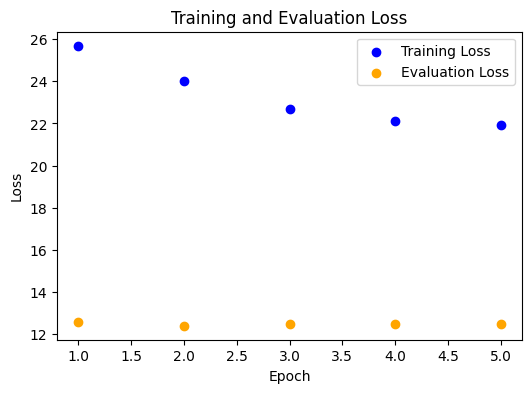

In [92]:
#### Plotting the loss valuesssssss
plt.figure(figsize=(6, 4))
plt.scatter(range(1,num_epochs+1), train_losses, label="Training Loss", color='blue')
plt.scatter(range(1,num_epochs+1), eval_losses, label="Evaluation Loss", color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

In [93]:
#Inference

#To evaluate the performance of a pretrained BERT model in predicting whether a second sentence follows the first,
# a function called predict_nsp is defined. The function operates as follows:

#Tokenization: The input sentences are tokenized using the tokenizer.encode_plus method, which returns a dictionary of tokenized inputs. These tokenized inputs are then converted into tensors and moved to the appropriate device for processing.

#Prediction: The BERT model is utilized to make predictions by passing the token and segment tensors as input.

#Logits Manipulation: The first element of the logits tensor is selected and unsqueezed to add an extra dimension, resulting in a shape of [1, 2].

#Probability and Prediction: The logits are passed through a softmax function to obtain probabilities, and the prediction is obtained by taking the argmax.

#Result Interpretation: The prediction is interpreted and returned as a string, indicating whether the second sentence follows the first or not.

#Example Usage: An example usage of the predict_nsp function is provided, demonstrating how two example sentences can be passed to the function along with a BERT model and tokenizer. The result is printed, indicating whether the second sentence follows the first based on the model's prediction.

#By utilizing the predict_nsp function, the performance of the pretrained BERT model in determining the relationship between two sentences can be assessed.


In [94]:
# Initialize the tokenizer with the BERT model's vocabulary
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.eval()

def predict_nsp(sentence1, sentence2, model, tokenizer):
    # Tokenize sentences with special tokens
    tokens = tokenizer.encode_plus(sentence1, sentence2, return_tensors="pt")
    tokens_tensor = tokens["input_ids"].to(device)
    segment_tensor = tokens["token_type_ids"].to(device)

    # Predict
    with torch.no_grad():
        # Assuming the model returns NSP predictions first
        nsp_prediction, _ = model(tokens_tensor, segment_tensor)
        # Select the first element (first sequence) of the logits tensor
        first_logits = nsp_prediction[0].unsqueeze(0)  # Adds an extra dimension, making it [1, 2]
        logits = torch.softmax(first_logits, dim=1)
        prediction = torch.argmax(logits, dim=1).item()

    # Interpret the prediction
    return "Second sentence follows the first" if prediction == 1 else "Second sentence does not follow the first"

# Example usage
sentence1 = "The cat sat on the mat."
sentence2 = "It was a sunny day"

print(predict_nsp(sentence1, sentence2, model, tokenizer))

Second sentence does not follow the first


In [95]:
#Second sentence follows the first

#A function is defined to perform Masked Language Modeling (MLM) using a pretrained BERT model. The function operates as follows:

#Tokenization: The input sentence is tokenized using the tokenizer and converted into token IDs, including the special tokens. The tokenized sentence is stored in the tokens_tensor variable.

#Segment Labels: Dummy segment labels filled with zeros are created and stored as segment_labels.

#Prediction: The BERT model is used to make predictions by passing the token tensor and segment labels as input. The MLM logits are extracted as predictions.

#Mask Token Index: The position of the [MASK] token is identified using the nonzero method and stored in the mask_token_index variable. Note that all tokens except the mask token are zero-padded.
# Predicted Index: The predicted index for the [MASK] token is obtained by taking the argmax of the MLM logits at the corresponding position.

#Token Conversion: The predicted index is converted back to a token using the convert_ids_to_tokens method of the tokenizer.

#Replaced Sentence: The original sentence is replaced with the predicted token at the position of the [MASK] token, resulting in the predicted sentence.



In [96]:
def predict_mlm(sentence, model, tokenizer):
    # Tokenize the input sentence and convert to token IDs, including special tokens
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens_tensor = inputs.input_ids

    # Create dummy segment labels filled with zeros, assuming it's needed by your model
    segment_labels = torch.zeros_like(tokens_tensor)

    with torch.no_grad():

        tokens_tensor = tokens_tensor.to(device)
        segment_labels = segment_labels.to(device)
        # Forward pass through the model, now correctly handling the output tuple
        output_tuple = model(tokens_tensor, segment_labels)

        # Assuming the second element of the tuple contains the MLM logits
        predictions = output_tuple[1]  # Adjusted based on your model's output

        # Identify the position of the [MASK] token
        mask_token_index = (tokens_tensor == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

        # Get the predicted index for the [MASK] token from the MLM logits
        predicted_index = torch.argmax(predictions[0, mask_token_index.item(), :], dim=-1)
        predicted_token = tokenizer.convert_ids_to_tokens([predicted_index.item()])[0]

        # Replace [MASK] in the original sentence with the predicted token
        predicted_sentence = sentence.replace(tokenizer.mask_token, predicted_token, 1)

    return predicted_sentence


# Example usage
sentence = "The cat sat on the [MASK]."
print(predict_mlm(sentence, model, tokenizer))

The cat sat on the [unused4].


In [97]:
# NSP example

from transformers import BertForPreTraining, BertTokenizer
import torch



# Load pretrained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pretrained model (weights)
model = BertForPreTraining.from_pretrained('bert-base-uncased')
# Prepare text pair for NSP
text_1 = "The cat sat on the mat"
text_2 = "It was a sunny day"
# Encode text
inputs = tokenizer(text_1, text_2, return_tensors="pt")

# Predict
with torch.no_grad():
    outputs = model(**inputs, next_sentence_label=torch.LongTensor([1]))
    nsp_logits = outputs.seq_relationship_logits

# Interpret the result for NSP
if torch.argmax(nsp_logits, dim=-1).item() == 0:
    print("The model thinks these sentences are NOT consecutive.")
else:
    print("The model thinks these sentences are consecutive.")

The model thinks these sentences are NOT consecutive.


In [98]:
#MLM example

from transformers import BertForPreTraining, BertTokenizer
import torch
from transformers import BertForPreTraining, BertTokenizer
import torch

# Load pretrained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pretrained model (weights)
model = BertForPreTraining.from_pretrained('bert-base-uncased')

# Prepare text with masked token
masked_text = "The capital of France is [MASK]."
# Tokenize and prepare for the model: Convert to tokens and add special tokens
input_ids = tokenizer(masked_text, return_tensors="pt")["input_ids"]

# Predict all tokens
with torch.no_grad():
    outputs = model(input_ids=input_ids)
    predictions = outputs.prediction_logits

# Confirm we were able to predict 'Paris' as the masked token
predicted_index = torch.argmax(predictions[0, input_ids[0] == tokenizer.mask_token_id]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])

print(f"Predicted token: {predicted_token}")


Predicted token: ['paris']
